# 3. Callbacks: Utilities for interacting with ML training

This blog aims to address one of the most common issues in machine learning: how to adjust training parameters on the fly when a performance metric is not looking so good. For example, a model may be stopped early (current epoch < max epochs) when a performance metric is not looking so good.

Sometimes this problem is easy to solve, for example the objective that monitors the training progress (e.g. the loss, accuracy, etc) stops improving, and that may get worse as training continues. In attacking this problem we will learn how to incorporate "callbacks," which will allow us to do lots of things including "early stopping".

We can achieve this by specifying some condition(s), and use them as a means for toggling the training. This could mean stopping training early, annealing the learning rate, or something else.

### Keras callbacks [(documentation)](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks)

Fortunatly, keras/tensorflow and torch have got you covered. The Model.fit() method in the Keras library admits a "callback" argument that allows you to feed into the training protocal a list of callback rules. I'll cover four examples below then show you how to write a custom callback. Visit the callbacks documentation page to see more options. 

##### (i) Early Stopping [(documentation)](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)
As the name implies, this callback will stop the training early, which means stop at some epoch when some metric stops improving.

In [1]:
from tensorflow.python.keras.callbacks import EarlyStopping

In [2]:
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=4,
    mode='max',
    min_delta=0, 
    verbose=0,
    baseline=None, 
    restore_best_weights=False
)

I've written out all of the possible arguments in this example. I frequently adjust the $\color{red}{\text{monitor}}$, $\color{red}{\text{patience}}$, and $\color{red}{\text{mode}}$ options in my work flows. $\color{red}{\text{Monitor}}$ is the metric that captures the progress of the training, $\color{red}{\text{patience}}$ is the number of epochs with no improvement after which training will be stopped, and $\color{red}{\text{mode}}$ is whether the monitor quantity should be maximimzed or minimized.

You still need to specifiy the number of epochs to train the model. When used with EarlyStopping the number you choose becomes the maximum number of epochs the model will get trained. In practice you want EarlyStopping to do the stopping, so pick a good number for the maximum number of epochs you are willing to work with! For example, if epochs = 40 but the loss is still improving, set the number of epochs to be a much larger number so that the training will continue on until no more progress is made after some number of epochs ($\color{red}{\text{patience}}$).

##### (ii) ModelCheckpoint [(documentation)](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint)
 
This callback enables one to save the model weights as training progresses.

In [3]:
from tensorflow.python.keras.callbacks import ModelCheckpoint

In [4]:
model_checkpoint = ModelCheckpoint(
    filepath, 
    monitor='val_loss', 
    verbose=0, 
    save_best_only=False,
    save_weights_only=False, 
    mode='auto', 
    save_freq='epoch', 
    options=None, 
    **kwargs
)

Most of the arguments should be pretty straight-forward. As always visit the documentation page for full descriptions and some example use-cases. The $\color{red}{\text{filepath}}$ argument must be specified (where the model weights will be saved), $\color{red}{\text{monitor}}$, which will be used to determine the best model weights, and the boolean arguments $\color{red}{\text{save_best_only}}$ and $\color{red}{\text{save_weights_only}}$, which are helpful options for specifying how and when to save the weights.

##### (iii) CSVLogger [(documentation)](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/CSVLogger)

Save the training metrics and other miscellaneous details you are monitoring to $\color{red}{\text{filename}}$ after every epoch. The metrics are initialized when Model.compile is called, which accepts a list of metrics that you chose (for example, metrics = $[\text{loss},~\text{val_loss},~\text{val_accuracy},~\dots]$). They are typically what gets printed to the screen from the progress bar when Model.fit gets called.

In [5]:
from tensorflow.python.keras.callbacks import CSVLogger

In [6]:
csv_logger = CSVLogger(
    filename, 
    separator=',', 
    append=False
)

Use the $\color{red}{\text{append}}$ argument when restarting training (e.g. set to True, otherwise False). You can save other things to the logger as well, such as the learning rate, using custom callbacks, which are discussed below.

##### (iv) LearningRateScheduler [(documentation)](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler) and ReduceLROnPlateau [(documentation)](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau)

The learning rate value can be adjusted while the model is training using the LearningRateScheduler callback, which allows us to specify how it should change. Additionally, the callback ReduceLROnPlateau is show-cased. In my experience this callback is very often a better choice to my custom specifications.

In [7]:
from tensorflow.python.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
import matplotlib.pyplot as plt
import math

Let us assume that we would like the learning rate to decay exponentially with epochs:

In [8]:
class CustomScheduler:
    
    def __init__(self, decay_constant = 10):
        self.decay = decay_constant
        
    def scheduler(self, epoch, lr):
        return lr * math.exp(-epoch / self.decay)

In [9]:
myScheduler = CustomScheduler()

Text(0, 0.5, 'learning rate')

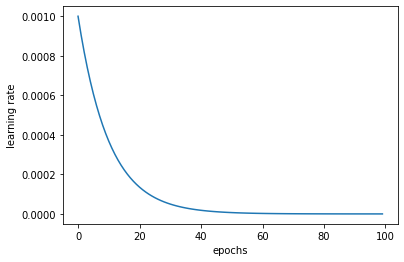

In [10]:
initial_lr = 0.001
epochs = list(range(100))
learning_rate = [myScheduler.scheduler(epoch, initial_lr) for epoch in epochs]

plt.plot(epochs, learning_rate)
plt.xlabel("epochs")
plt.ylabel("learning rate")

Now the custom rule can be turned into a Callbacks object using LearningRateScheduler:

In [11]:
callback = LearningRateScheduler(myScheduler.scheduler)

And thats it! I purposefully created CustomScheduler as a class (rather than a method), so that I could insert custom parameters, in this case the exponential decay constant. Ok, next let's take a look at ReduceLROnPlateau.

As its name suggests, the learning rate is changed by a factor anytime the quantity being measured reaches a performance benchmark high-water mark, that then regresses or fails to improve further (the metric has plateued).

In [12]:
lr_annealer = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1, 
    patience=10, 
    verbose=0, 
    mode='auto',
    min_delta=0.0001, 
    cooldown=0, 
    min_lr=0, 
    **kwargs
)

##### (v) Custom callbacks [(documentation)](https://www.tensorflow.org/guide/keras/custom_callback)

We only know the learning rate dependency on epochs if the relationship is explicitly defined, as is the case an exponential annealing protocol. However, when using ReduceLROnPlateau (and in general) it can be convenient to track the learning rate as training progresses, by printing it to the screen during training, and by saving it to the CSVLogger filename if that callback has also been used. To do this, we will write a custom callback.

In [13]:
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.callbacks import Callback

In [14]:
class LearningRateTracker(Callback):
    def on_epoch_end(self, epoch, logs = {}):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

### Using Callbacks when training

In Keras, models are trained when enacting the Model.fit call, which is where we insert our callbacks. First make a list of our Keras.callbacks objects defined earlier,

In [15]:
callbacks = [
    early_stopping, model_checkpoint, csv_logger, lr_annealer, custom_callback
]

Then this list is simply inserted as an extra argument to the call to Model.fit like so:

In [16]:
Model.fit(
    x_data, y_data,
    callbacks = callbacks,
    ...,
)

And thats it! In some cases the callbacks will print information to the screen (you can control that output typically via the verbose argument).

### pyTorch callbacks

Callbacks can also be implemented with the (py)Torch library. Unless you are using a custom library thats build on Torch, one has to train the model at a lower level as compared to Keras, where training was taken care of with the Model.fit method.

I will cover how to write custom Trainer objects in detail in a future post, but in general to train a model we will minimally require a method to train the model for one epoch, and a method to validate (or test) the model. For example,

In [17]:
class Trainer:
    
    def __init__(self, epochs):
        self.epochs = epochs
        
    def train_one_epoch(self, epoch):
        # Loop over data and estimate epoch loss
        return loss
    
    def test(self, epoch):
        # Run the model in predict mode and predict on a validation holdout set
        return test_loss
    
    def train(self):
        for epoch in epochs:
            loss = self.train_one_epoch(epoch)
            test_loss = self.test(epoch)

The Trainer.train class method loops over the total number of epochs and trains and tests the model at each epoch.

Let's insert a call to anneal the learning rate on plateau into the custom Trainer object:

In [18]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [19]:
scheduler = ReduceLROnPlateau(**config)

In [20]:
class Trainer:
    
    ...
    
    def train(self):
        for epoch in epochs:
            loss = self.train_one_epoch(epoch)
            test_loss = self.test(epoch)
            scheduler.step()

Note that you should only call the scheduler after updating the optimizer. That's it!

Email any questions / mistakes / whatever to John Schreck, schreck@ucar.edu